In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
#code
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"dataset not found: {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f" dataset loaded: {df.shape}")
print(f"\n columns overview:")
print(df.columns.tolist())


 dataset loaded: (73111, 30)

 columns overview:
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


In [28]:
df_model = df.copy()
le = LabelEncoder()
for col in df_model.select_dtypes(include=['object', 'category']).columns:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

drop_cols = [c for c in [ 'price_clean', 'target_class'] if c in df_model.columns]
X = df_model.drop(columns=drop_cols).select_dtypes(include=[np.number])
X = X.fillna(X.median())
y = df['target_class'].values

CLASS_COLORS = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']
CLASS_LABELS = ['Cl.0 – Très bas', 'Cl.1 – Bas-moyen', 'Cl.2 – Haut-moyen', 'Cl.3 – Très haut']
CLASS_SHORT  = ['Cl.0', 'Cl.1', 'Cl.2', 'Cl.3']

print(f"✅ Dataset : {df.shape[0]} observations × {X.shape[1]} features")
print(f"   Distribution de target_class :")
for c in range(4):
    print(f"     Classe {c} : {np.sum(y==c):>5d} obs. ({np.mean(y==c)*100:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.3, random_state=42, stratify=y
)


✅ Dataset : 73111 observations × 22 features
   Distribution de target_class :
     Classe 0 : 19114 obs. (26.1%)
     Classe 1 : 17449 obs. (23.9%)
     Classe 2 : 18299 obs. (25.0%)
     Classe 3 : 18249 obs. (25.0%)


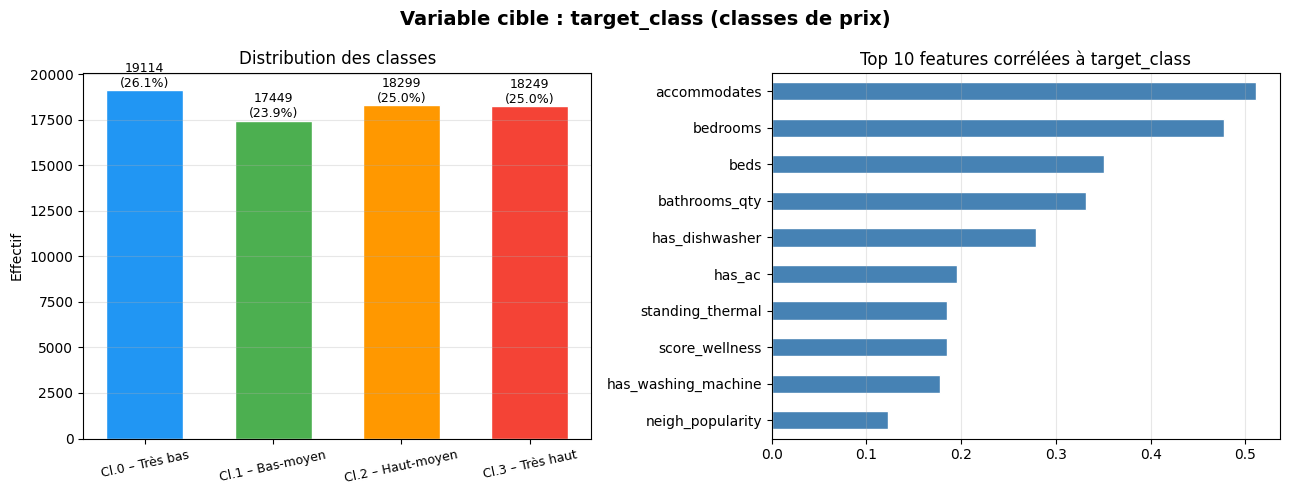

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Variable cible : target_class (classes de prix)", fontsize=14, fontweight='bold')

counts = pd.Series(y).value_counts().sort_index()
bars = axes[0].bar(range(4), counts.values, color=CLASS_COLORS, edgecolor='white', width=0.6)
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(CLASS_LABELS, rotation=12, fontsize=9)
axes[0].set_ylabel("Effectif")
axes[0].set_title("Distribution des classes")
for bar, v in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 5,
                 f'{v}\n({v/len(y)*100:.1f}%)', ha='center', va='bottom', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# Prix moyen par classe (si disponible)
if 'prix' in df.columns:
    prix_by_class = [df[df['target_class'] == c]['prix'].values for c in range(4)]
    bp = axes[1].boxplot(prix_by_class, patch_artist=True, labels=CLASS_SHORT)
    for patch, color in zip(bp['boxes'], CLASS_COLORS):
        patch.set_facecolor(color); patch.set_alpha(0.7)
    axes[1].set_title("Distribution du prix par classe")
    axes[1].set_ylabel("Prix")
    axes[1].grid(axis='y', alpha=0.3)
else:
    # Heatmap des corrélations top features avec target
    corr = pd.DataFrame(X, columns=X.columns if hasattr(X, 'columns') else range(X.shape[1]))
    top_feat = pd.DataFrame(X, columns=df_model.drop(columns=drop_cols)
                            .select_dtypes(include=[np.number]).columns)
    top_feat['target'] = y
    top_corr = top_feat.corr()['target'].drop('target').abs().sort_values(ascending=False).head(10)
    top_corr.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='white')
    axes[1].set_title("Top 10 features corrélées à target_class")
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


═════════════════════════════════════════════════════════════════
  BOOTSTRAP — Stabilité de target_class
═════════════════════════════════════════════════════════════════
  Moyenne observée : 1.4881
  IC 95% bootstrap : [1.4806 ; 1.4951]

  IC 95% des proportions par classe :
    Classe 0 : 0.261 ± 0.0016  IC95% [0.258 ; 0.264]
    Classe 1 : 0.239 ± 0.0016  IC95% [0.236 ; 0.242]
    Classe 2 : 0.250 ± 0.0016  IC95% [0.247 ; 0.253]
    Classe 3 : 0.250 ± 0.0016  IC95% [0.247 ; 0.253]


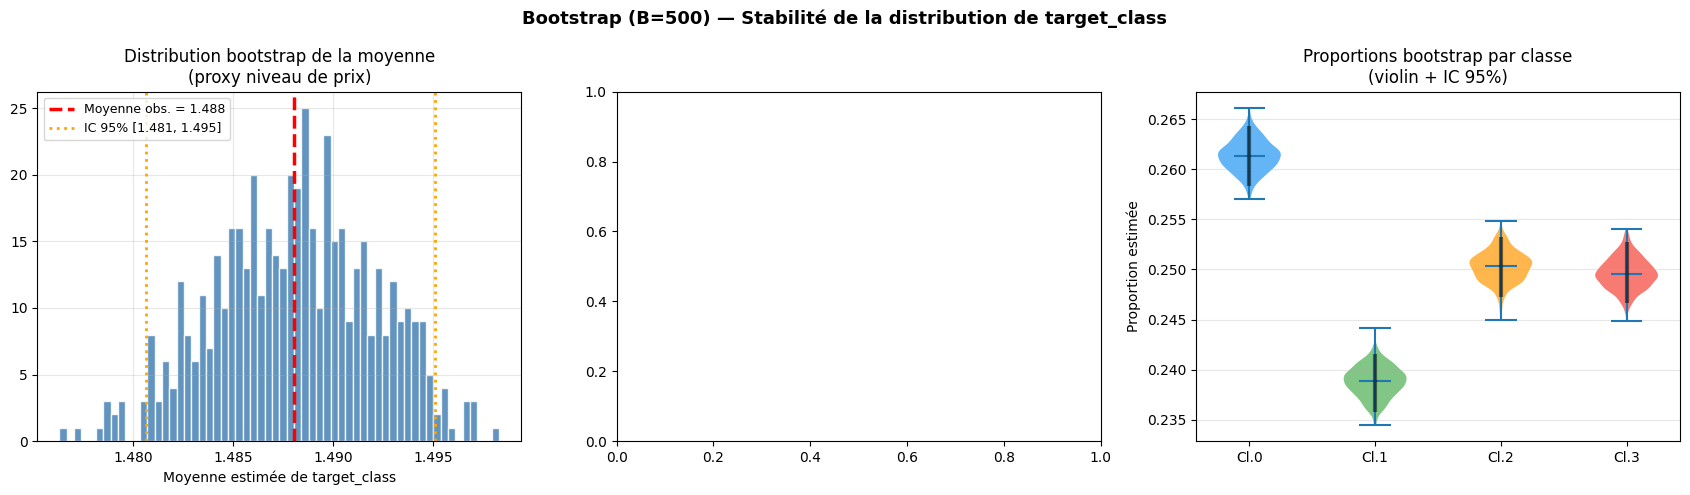

In [31]:
print("\n" + "═"*65)
print("  BOOTSTRAP — Stabilité de target_class")
print("═"*65)

N_BOOT = 500
bootstrap_props  = {c: [] for c in range(4)}
bootstrap_means  = []

for _ in range(N_BOOT):
    s = resample(y, replace=True, n_samples=len(y))
    bootstrap_means.append(np.mean(s))
    for c in range(4):
        bootstrap_props[c].append(np.mean(s == c))

bootstrap_means = np.array(bootstrap_means)
ci_low  = np.percentile(bootstrap_means, 2.5)
ci_high = np.percentile(bootstrap_means, 97.5)

print(f"  Moyenne observée : {np.mean(y):.4f}")
print(f"  IC 95% bootstrap : [{ci_low:.4f} ; {ci_high:.4f}]")
print(f"\n  IC 95% des proportions par classe :")
for c in range(4):
    p = np.array(bootstrap_props[c])
    print(f"    Classe {c} : {p.mean():.3f} ± {p.std():.4f}  "
          f"IC95% [{np.percentile(p,2.5):.3f} ; {np.percentile(p,97.5):.3f}]")

fig2, axes2 = plt.subplots(1, 3, figsize=(17, 5))
fig2.suptitle(f"Bootstrap (B={N_BOOT}) — Stabilité de la distribution de target_class",
              fontsize=13, fontweight='bold')

# Histogramme de la moyenne bootstrap
axes2[0].hist(bootstrap_means, bins=60, color='steelblue', edgecolor='white', alpha=0.85)
axes2[0].axvline(np.mean(y), color='red',    lw=2.5, linestyle='--',
                 label=f'Moyenne obs. = {np.mean(y):.3f}')
axes2[0].axvline(ci_low,     color='orange', lw=2,   linestyle=':',
                 label=f'IC 95% [{ci_low:.3f}, {ci_high:.3f}]')
axes2[0].axvline(ci_high,    color='orange', lw=2,   linestyle=':')
axes2[0].set_title("Distribution bootstrap de la moyenne\n(proxy niveau de prix)")
axes2[0].set_xlabel("Moyenne estimée de target_class")
axes2[0].legend(fontsize=9)
axes2[0].grid(alpha=0.3)

# Violin plot des proportions par classe
vp_data = [bootstrap_props[c] for c in range(4)]
parts = axes2[2].violinplot(vp_data, positions=range(4), showmedians=True,
                            showextrema=True)
for i, (body, color) in enumerate(zip(parts['bodies'], CLASS_COLORS)):
    body.set_facecolor(color); body.set_alpha(0.7)
# IC 95%
for c in range(4):
    p = np.array(bootstrap_props[c])
    axes2[2].vlines(c, np.percentile(p, 2.5), np.percentile(p, 97.5),
                    color='black', lw=3, alpha=0.5)
axes2[2].set_xticks(range(4))
axes2[2].set_xticklabels(CLASS_SHORT)
axes2[2].set_title("Proportions bootstrap par classe\n(violin + IC 95%)")
axes2[2].set_ylabel("Proportion estimée")
axes2[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



═════════════════════════════════════════════════════════════════
  BAGGING — Convergence OOB selon B
═════════════════════════════════════════════════════════════════
  CART seul (erreur test) : 0.5462
  OOB minimale : 0.4598  (B=295)


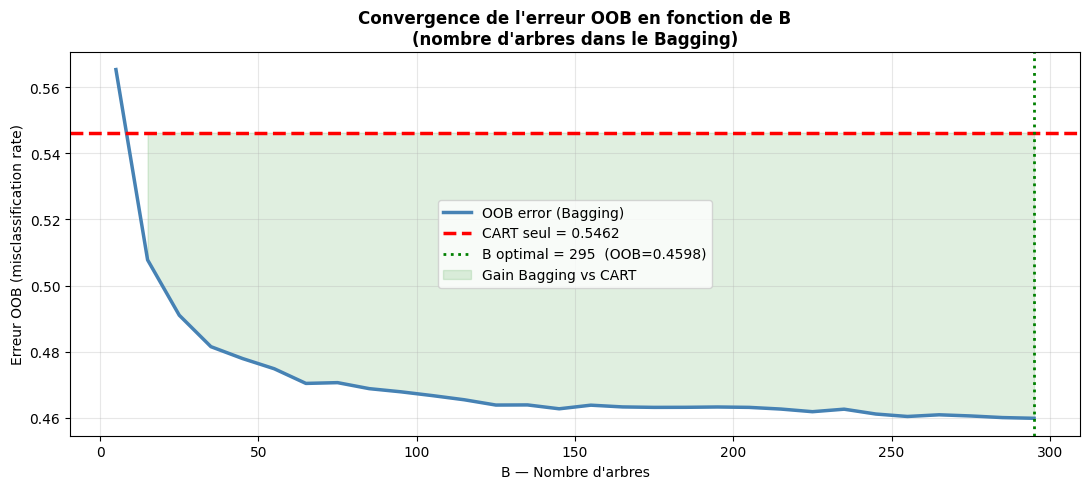

In [32]:
print("\n" + "═"*65)
print("  BAGGING — Convergence OOB selon B")
print("═"*65)

B_range  = list(range(5, 301, 10))
oob_errs = []

for b_val in B_range:
    bag_tmp = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=b_val,
        bootstrap=True, oob_score=True,
        random_state=42, n_jobs=-1
    )
    bag_tmp.fit(X_train, y_train)
    oob_errs.append(1 - bag_tmp.oob_score_)

# Erreur de test CART seul
cart_ref = DecisionTreeClassifier(random_state=42)
cart_ref.fit(X_train, y_train)
err_cart_ref = 1 - accuracy_score(y_test, cart_ref.predict(X_test))
print(f"  CART seul (erreur test) : {err_cart_ref:.4f}")

# B optimal
best_B   = B_range[np.argmin(oob_errs)]
best_oob = min(oob_errs)
print(f"  OOB minimale : {best_oob:.4f}  (B={best_B})")

fig3, ax3 = plt.subplots(figsize=(11, 5))
ax3.plot(B_range, oob_errs, color='steelblue', lw=2.5, label='OOB error (Bagging)')
ax3.axhline(err_cart_ref, color='red', linestyle='--', lw=2.5,
            label=f'CART seul = {err_cart_ref:.4f}')
ax3.axvline(best_B, color='green', linestyle=':', lw=2,
            label=f'B optimal = {best_B}  (OOB={best_oob:.4f})')
ax3.fill_between(B_range, oob_errs, err_cart_ref,
                 where=[o < err_cart_ref for o in oob_errs],
                 alpha=0.12, color='green', label='Gain Bagging vs CART')
ax3.set_title("Convergence de l'erreur OOB en fonction de B\n(nombre d'arbres dans le Bagging)",
              fontsize=12, fontweight='bold')
ax3.set_xlabel("B — Nombre d'arbres")
ax3.set_ylabel("Erreur OOB (misclassification rate)")
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)
plt.tight_layout()
plt.show()

  CART    : 0.5478 ± 0.0031
  Bagging : 0.4649 ± 0.0029
  Bagging < CART dans 50/50 simulations


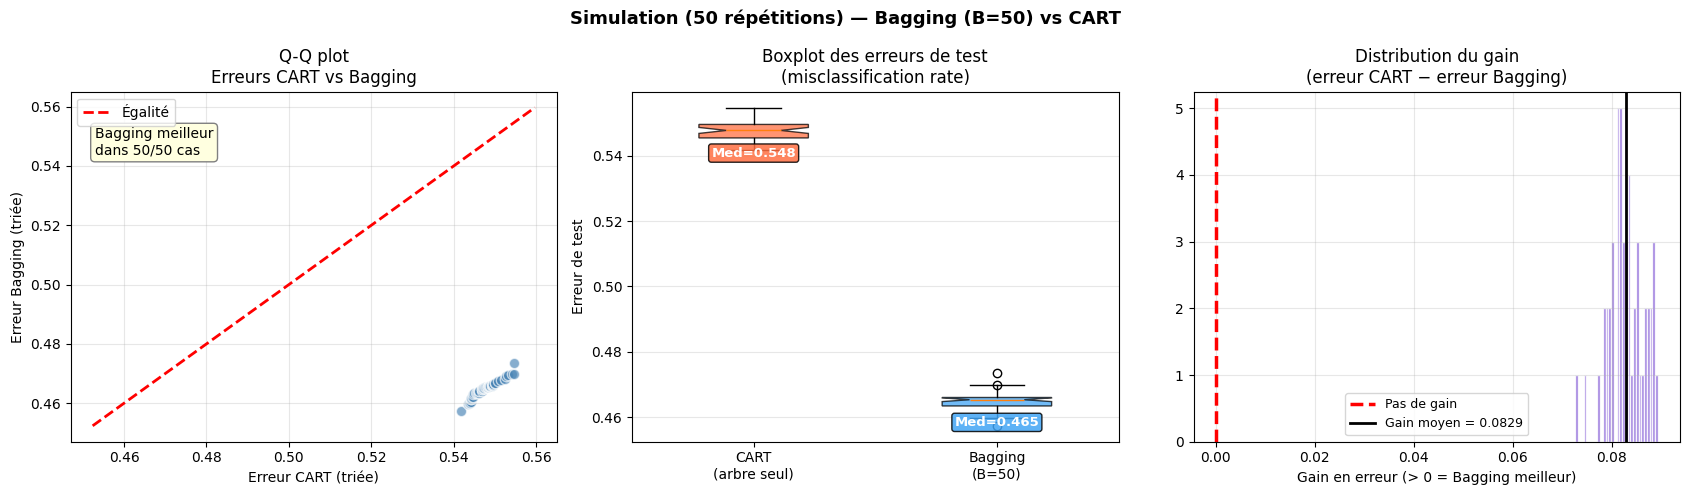

In [34]:
N_SIM = 50
B_SIM = 50
errors_cart, errors_bag = [], []

for sim in range(N_SIM):
    Xtr, Xte, ytr, yte = train_test_split(
        X.values, y, test_size=0.3, random_state=sim, stratify=y
    )
    c = DecisionTreeClassifier(random_state=sim)
    c.fit(Xtr, ytr)
    errors_cart.append(1 - accuracy_score(yte, c.predict(Xte)))

    b = BaggingClassifier(estimator=DecisionTreeClassifier(),
                          n_estimators=B_SIM, bootstrap=True,
                          random_state=sim, n_jobs=-1)
    b.fit(Xtr, ytr)
    errors_bag.append(1 - accuracy_score(yte, b.predict(Xte)))

errors_cart = np.array(errors_cart)
errors_bag  = np.array(errors_bag)

print(f"  CART    : {errors_cart.mean():.4f} ± {errors_cart.std():.4f}")
print(f"  Bagging : {errors_bag.mean():.4f} ± {errors_bag.std():.4f}")
print(f"  Bagging < CART dans {np.sum(errors_bag < errors_cart)}/{N_SIM} simulations")

fig4, axes4 = plt.subplots(1, 3, figsize=(17, 5))
fig4.suptitle(f"Simulation ({N_SIM} répétitions) — Bagging (B={B_SIM}) vs CART",
              fontsize=13, fontweight='bold')

# Q-Q plot
axes4[0].scatter(np.sort(errors_cart), np.sort(errors_bag),
                 color='steelblue', alpha=0.65, s=55, edgecolors='white')
lims = [min(errors_cart.min(), errors_bag.min()) - 0.005,
        max(errors_cart.max(), errors_bag.max()) + 0.005]
axes4[0].plot(lims, lims, 'r--', lw=2, label='Égalité')
axes4[0].set_title("Q-Q plot\nErreurs CART vs Bagging")
axes4[0].set_xlabel("Erreur CART (triée)")
axes4[0].set_ylabel("Erreur Bagging (triée)")
axes4[0].legend()
axes4[0].grid(alpha=0.3)
n_better = np.sum(errors_bag < errors_cart)
axes4[0].annotate(f"Bagging meilleur\ndans {n_better}/{N_SIM} cas",
                  xy=(0.05, 0.82), xycoords='axes fraction', fontsize=10,
                  bbox=dict(boxstyle='round', fc='lightyellow', ec='gray'))

# Boxplot
bp4 = axes4[1].boxplot([errors_cart, errors_bag],
                       labels=['CART\n(arbre seul)', f'Bagging\n(B={B_SIM})'],
                       patch_artist=True, widths=0.45, notch=True)
bp4['boxes'][0].set_facecolor('#FF7043'); bp4['boxes'][0].set_alpha(0.75)
bp4['boxes'][1].set_facecolor('#42A5F5'); bp4['boxes'][1].set_alpha(0.75)
axes4[1].set_title("Boxplot des erreurs de test\n(misclassification rate)")
axes4[1].set_ylabel("Erreur de test")
for i, (errs, col) in enumerate(zip([errors_cart, errors_bag], ['#FF7043', '#42A5F5']), 1):
    axes4[1].text(i, np.median(errs) - 0.008,
                  f'Med={np.median(errs):.3f}', ha='center', fontsize=9.5,
                  fontweight='bold', color='white',
                  bbox=dict(boxstyle='round,pad=0.2', fc=col, alpha=0.85))
axes4[1].grid(axis='y', alpha=0.3)

# Distribution des différences
diffs = errors_cart - errors_bag
axes4[2].hist(diffs, bins=30, color='mediumpurple', edgecolor='white', alpha=0.85)
axes4[2].axvline(0,             color='red',    lw=2.5, linestyle='--', label='Pas de gain')
axes4[2].axvline(diffs.mean(),  color='black',  lw=2,   linestyle='-',
                 label=f'Gain moyen = {diffs.mean():.4f}')
axes4[2].set_title("Distribution du gain\n(erreur CART − erreur Bagging)")
axes4[2].set_xlabel("Gain en erreur (> 0 = Bagging meilleur)")
axes4[2].legend(fontsize=9)
axes4[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


═════════════════════════════════════════════════════════════════
  ESTIMATEURS DE PRÉCISION — Test / CV / OOB
═════════════════════════════════════════════════════════════════
  Erreur test (70/30)   : 0.4597
  5-fold CV             : 0.4585 ± 0.0030
  10-fold CV            : 0.4558 ± 0.0044
  OOB error             : 0.4580


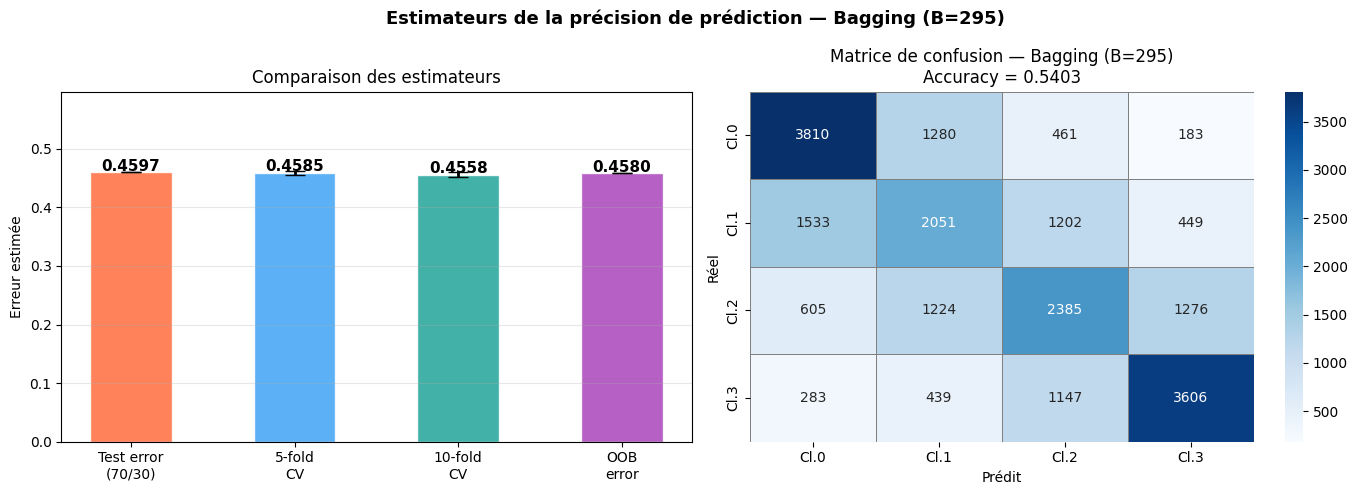

In [37]:
print("\n" + "═"*65)
print("  ESTIMATEURS DE PRÉCISION — Test / CV / OOB")
print("═"*65)

B_FINAL = best_B

# Test error
bag_test = BaggingClassifier(estimator=DecisionTreeClassifier(),
                             n_estimators=B_FINAL, bootstrap=True,
                             random_state=42, n_jobs=-1)
bag_test.fit(X_train, y_train)
err_test = 1 - accuracy_score(y_test, bag_test.predict(X_test))

# CV 5 et 10 fold
cv_res = {}
for k in [5, 10]:
    bag_cv = BaggingClassifier(estimator=DecisionTreeClassifier(),
                               n_estimators=B_FINAL, bootstrap=True, random_state=42)
    scores = cross_val_score(bag_cv, X.values, y, cv=StratifiedKFold(k, shuffle=True, random_state=42),
                             scoring='accuracy', n_jobs=-1)
    cv_res[k] = 1 - scores

# OOB
bag_oob = BaggingClassifier(estimator=DecisionTreeClassifier(),
                            n_estimators=B_FINAL, bootstrap=True,
                            oob_score=True, random_state=42, n_jobs=-1)
bag_oob.fit(X.values, y)
err_oob = 1 - bag_oob.oob_score_

print(f"  Erreur test (70/30)   : {err_test:.4f}")
print(f"  5-fold CV             : {cv_res[5].mean():.4f} ± {cv_res[5].std():.4f}")
print(f"  10-fold CV            : {cv_res[10].mean():.4f} ± {cv_res[10].std():.4f}")
print(f"  OOB error             : {err_oob:.4f}")

labels5  = ['Test error\n(70/30)', '5-fold\nCV', '10-fold\nCV', 'OOB\nerror']
means5   = [err_test, cv_res[5].mean(), cv_res[10].mean(), err_oob]
stds5    = [0, cv_res[5].std(), cv_res[10].std(), 0]
colors5  = ['#FF7043', '#42A5F5', '#26A69A', '#AB47BC']

fig5, axes5 = plt.subplots(1, 2, figsize=(14, 5))
fig5.suptitle(f"Estimateurs de la précision de prédiction — Bagging (B={B_FINAL})",
              fontsize=13, fontweight='bold')

bars5 = axes5[0].bar(labels5, means5, color=colors5, edgecolor='white',
                     width=0.5, alpha=0.87)
axes5[0].errorbar(range(4), means5, yerr=stds5,
                  fmt='none', color='black', capsize=7, lw=2)
for bar, val in zip(bars5, means5):
    axes5[0].text(bar.get_x() + bar.get_width()/2, val + 0.003,
                  f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
axes5[0].set_ylabel("Erreur estimée")
axes5[0].set_title("Comparaison des estimateurs")
axes5[0].set_ylim(0, max(means5) * 1.3)
axes5[0].grid(axis='y', alpha=0.3)

# Matrice de confusion du meilleur modèle
y_pred_final = bag_test.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes5[1],
            xticklabels=CLASS_SHORT, yticklabels=CLASS_SHORT,
            linewidths=0.5, linecolor='gray')
axes5[1].set_title(f"Matrice de confusion — Bagging (B={B_FINAL})\n"
                   f"Accuracy = {1-err_test:.4f}")
axes5[1].set_xlabel("Prédit")
axes5[1].set_ylabel("Réel")

plt.tight_layout()
plt.show()